# Relax_Challenge

The data is available as two attached CSV files:  
> takehome_user_engagement.csv  
takehome_users.csv  

The data has the following two tables:  
   
1] A user table ( "takehome_users" ) with data on 12,000 users who signed up for the  
product in the last two years. This table includes:
> ● **name:** the user's name  
  ● **object_id:** the user's id  
  ● **email:** email address  
  ● **creation_source:** how their account was created. This takes on one of 5 values:  
>>  ○ **PERSONAL_PROJECTS:** invited to join another user's personal workspace  
    ○ **GUEST_INVITE:** invited to an organization as a guest (limited permissions)  
    ○ **ORG_INVITE:** invited to an organization (as a full member)  
    ○ **SIGNUP:** signed up via the website  
    ○ **SIGNUP_GOOGLE_AUTH:** signed up using Google  
      Authentication (using a Google email account for their login id)

> ● **creation_time:** when they created their account  
  ● **last_session_creation_time:** unix timestamp of last login  
  ● **opted_in_to_mailing_list:** whether they have opted into receiving marketing emails  
  ● **enabled_for_marketing_drip:** whether they are on the regular marketing email drip  
  ● **org_id:** the organization (group of users) they belong to  
  ● **invited_by_user_id:** which user invited them to join (if applicable).  

2] A usage summary table ( "takehome_user_engagement" ) that has a row for each day  
that a user logged into the product.

Defining an "adopted user" as a user who has logged into the product on three separate  
days in at least one seven-day period, **identify which factors predict future user  
adoption.**    

We suggest spending 1-2 hours on this, but you're welcome to spend more or less.  
Please send us a brief writeup of your findings (the more concise, the better no more  
than one page), along with any summary tables, graphs, code, or queries that can help  
us understand your approach. Please note any factors you considered or investigation  
you did, even if they did not pan out. Feel free to identify any further research or data  
you think would be valuable.

In [1]:
# packages
import os
import pandas as pd
import numpy  as np
import csv
from datetime import datetime
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

#with warnings.catch_warnings():
#    warnings.filterwarnings("ignore",category=DeprecationWarning)
#    import sklearn
# required machine learning packages
from sklearn import model_selection
from sklearn import linear_model, tree, discriminant_analysis, naive_bayes, ensemble, gaussian_process
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import log_loss, confusion_matrix

#from sklearn.feature_selection import RFE
#from sklearn.metrics import brier_score_loss, roc_auc_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.dummy import DummyRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV as CCV
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
import xgboost as xgb

In [3]:
# takehome_user_engagement - row for each day that a user logged into the product
engagement = pd.read_csv("takehome_user_engagement.csv", parse_dates=['time_stamp'])
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'].dt.date)
engagement.info()
engagement.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


,time_stamp,user_id,visited
0,2014-04-22,1,1
1,2013-11-15,2,1
2,2013-11-29,2,1
3,2013-12-09,2,1
4,2013-12-25,2,1


In [4]:
engagement.sort_values(by=['user_id','time_stamp'],inplace=True)
engagement['seven_day_count'] = (engagement.groupby(['user_id'])
                            .rolling('7d', min_periods=1, on='time_stamp')['visited']
                            .sum().reset_index(drop=True))
engagement = engagement.loc[engagement.groupby('user_id')['seven_day_count'].idxmax()]
engagement['adopted_user'] = np.where(engagement.seven_day_count>=3, 1, 0)
engagement.drop_columns(['time_stamp'])
engagement.head(20)

,time_stamp,user_id,visited,seven_day_count,adopted_user
0,2014-04-22,1,1,1.0,0
9,2014-02-09,2,1,3.0,1
15,2013-03-19,3,1,1.0,0
16,2013-05-22,4,1,1.0,0
17,2013-01-22,5,1,1.0,0
18,2013-12-19,6,1,1.0,0
19,2012-12-20,7,1,1.0,0
191,2014-01-28,10,1,7.0,1
304,2013-12-27,11,1,1.0,0
305,2014-03-30,13,1,1.0,0


In [36]:
users = pd.read_csv('takehome_users.csv', encoding='iso-8859-1', parse_dates=[ 'creation_time', 'last_session_creation_time'])
users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   object        
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 937.6+ KB


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1398138810,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1396237504,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1363734892,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1369210168,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1358849660,0,0,193,5240.0


In [37]:
users['adopted_user'] = users.object_id.map(engagement.set_index('user_id')['adopted_user'])
users.adopted_user.fillna(0, inplace=True)
users['invited'] = np.where(users.invited_by_user_id > 0, 1, 0)
users.head(20)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,invited
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1398138810,1,0,11,10803.0,0.0,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1396237504,0,0,1,316.0,1.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1363734892,0,0,94,1525.0,0.0,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1369210168,0,0,1,5151.0,0.0,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1358849660,0,0,193,5240.0,0.0,1
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1387424226,0,0,197,11241.0,0.0,1
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1356009872,0,1,37,NaN,0.0,0
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,NaN,0.0,0
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,NaN,0.0,0
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1401833283,1,1,318,4143.0,1.0,1


In [38]:
users.drop(columns=['object_id','creation_time','name','email','creation_source','last_session_creation_time','invited_by_user_id'],inplace=True)
users.head(20)

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted_user,invited
0,1,0,11,0.0,1
1,0,0,1,1.0,1
2,0,0,94,0.0,1
3,0,0,1,0.0,1
4,0,0,193,0.0,1
5,0,0,197,0.0,1
6,0,1,37,0.0,0
7,1,1,74,0.0,0
8,0,0,302,0.0,0
9,1,1,318,1.0,1


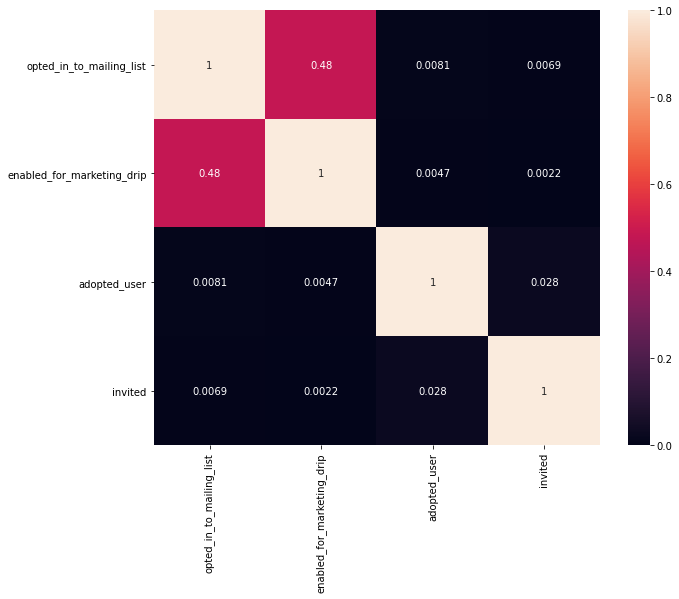

In [40]:
feature_cols = users[['opted_in_to_mailing_list',
                      'enabled_for_marketing_drip',
                      'adopted_user',
                      'invited']]
plt.subplots(figsize=(10,8))
sns.heatmap(feature_cols.corr(), annot=True, vmin=0, vmax=1);

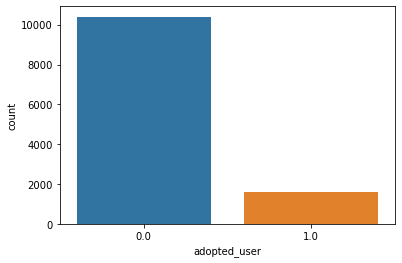

In [41]:
import seaborn as sns
sns.countplot(users['adopted_user'],label="Count")

In [42]:
df=users

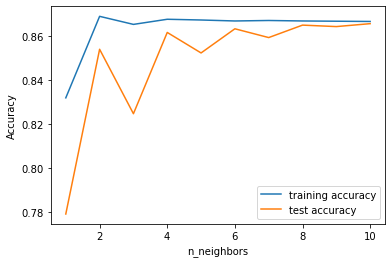

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'adopted_user'], df['adopted_user'], stratify=df['adopted_user'], random_state=66)
from sklearn.neighbors import KNeighborsClassifier
training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 10
neighbors_settings = range(1, 11)
for n_neighbors in neighbors_settings:
    # build the model
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(knn.score(X_train, y_train))
    # record test set accuracy
    test_accuracy.append(knn.score(X_test, y_test))
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()
plt.savefig('knn_compare_model')

In [44]:
nn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'.format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'.format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.87
Accuracy of K-NN classifier on test set: 0.87


In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(X_train, y_train)

print("Training set score: {:.3f}".format(pipe.score(X_train, y_train)))
print("Test set score: {:.3f}".format(pipe.score(X_test, y_test)))

Training set score: 0.866
Test set score: 0.867


In [46]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=7, random_state=0)
tree.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 0.867
Accuracy on test set: 0.865


In [49]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=0)
gb.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(gb.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gb.score(X_test, y_test)))

Accuracy on training set: 0.867
Accuracy on test set: 0.867


In [50]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, y_train)
print("Accuracy on training set: {:.2f}".format(svc.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(X_test, y_test)))

Accuracy on training set: 0.87
Accuracy on test set: 0.87


In [51]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
svc = SVC()
svc.fit(X_train_scaled, y_train)
print("Accuracy on training set: {:.2f}".format(svc.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(X_test_scaled, y_test)))

Accuracy on training set: 0.87
Accuracy on test set: 0.87


In [59]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['adopted_user']),df.adopted_user,test_size=0.3, random_state=42)

In [60]:
df2 = pd.get_dummies(df)
df2

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted_user,invited
0,1,0,11,0.0,1
1,0,0,1,1.0,1
2,0,0,94,0.0,1
3,0,0,1,0.0,1
4,0,0,193,0.0,1
...,...,...,...,...,...
11995,0,0,89,0.0,1
11996,0,0,200,0.0,0
11997,1,1,83,0.0,1
11998,0,0,6,0.0,0


In [61]:
#from sklearn.model_selection import train_test_split
y = df['adopted_user']
X = df2.drop(['adopted_user'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

In [62]:
#scale data
from sklearn import preprocessing
import numpy as np
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,log_loss
from sklearn.metrics import f1_score

clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.838
Random Forest: f1-score=0.792


4


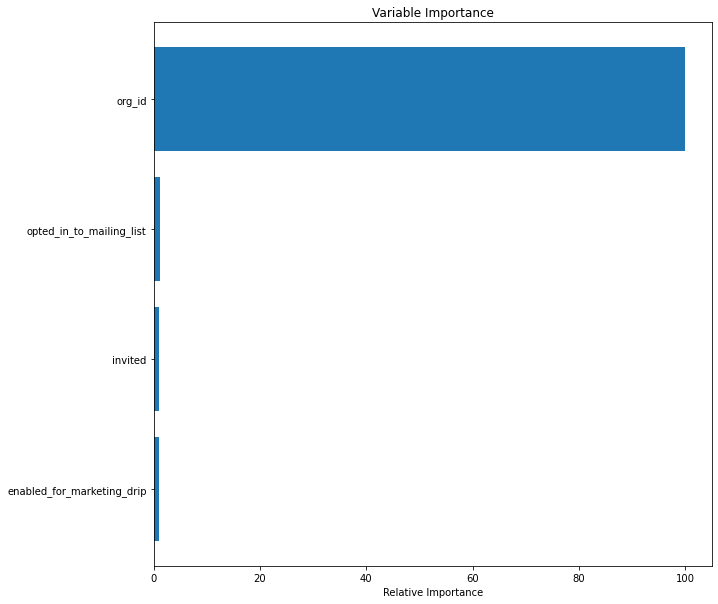

In [64]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

###### Summary
The organization that the user belongs to has a high correlation to whether the user will be an adopted user or not.